In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings

warnings.filterwarnings('ignore')
% matplotlib inline

In [4]:
features = pd.read_csv('data/temps.csv')

features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [5]:
print("数据维度：", features.shape)

数据维度： (348, 9)


In [6]:
# 处理时间数据
import datetime

years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [7]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

In [8]:
# one-hot编码
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [9]:
# 标签
labels = np.array(features['actual'])
# 去掉标签列
features = features.drop('actual', axis=1)
# 列名字单独保存一下
features_list = list(features.columns)
# 转换格式
features = np.array(features)
features, labels, features_list

(array([[2.016e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.016e+03, 1.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.016e+03, 1.000e+00, 3.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [2.016e+03, 1.200e+01, 2.900e+01, ..., 1.000e+00, 0.000e+00,
         0.000e+00],
        [2.016e+03, 1.200e+01, 3.000e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.016e+03, 1.200e+01, 3.100e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([45, 44, 41, 40, 44, 51, 45, 48, 50, 52, 45, 49, 55, 49, 48, 54, 50,
        54, 48, 52, 52, 57, 48, 51, 54, 56, 57, 56, 52, 48, 47, 46, 51, 49,
        49, 53, 49, 51, 57, 62, 56, 55, 58, 55, 56, 57, 53, 51, 53, 51, 51,
        60, 59, 61, 60, 57, 53, 58, 55, 59, 57, 64, 60, 53, 54, 55, 56, 55,
        52, 54, 49, 51, 53, 58, 63, 61, 55, 56, 57, 53, 54, 57, 59, 51, 56,
        64, 68, 73, 71, 63, 69, 60, 57, 68, 77, 76, 66, 59, 58, 6

In [10]:
features.shape

(348, 14)

In [11]:
from sklearn import preprocessing

# 数据归一化
input_features = preprocessing.StandardScaler().fit_transform(features)

In [12]:
input_features

array([[ 0.        , -1.5678393 , -1.65682171, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.54267126, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.4285208 , ..., -0.40482045,
        -0.41913682, -0.40482045],
       ...,
       [ 0.        ,  1.5810006 ,  1.53939107, ...,  2.47023092,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.65354153, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.76769198, ..., -0.40482045,
        -0.41913682, -0.40482045]])

### 构建网络模型

In [20]:
x = torch.tensor(input_features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float)
#
# 权重参数初始化
weights = torch.randn((14, 128), dtype=torch.float, requires_grad=True)
biases = torch.randn(128, dtype=torch.float, requires_grad=True)
weights2 = torch.randn((128, 1), dtype=torch.float, requires_grad=True)
biases2 = torch.randn(1, dtype=torch.float, requires_grad=True)
#
learning_rate = 0.001
losses = []
#
for i in range(1000):
    hidden = x.mm(weights) + biases

    hidden = torch.relu(hidden)

    predictions = hidden.mm(weights2) + biases2

    loss = torch.mean((predictions - y) ** 2)

    losses.append(loss.data.numpy())

    if i % 100 == 0:
        print(f"loss:{loss}")
    # 反向传播
    loss.backward()
    # 更新参数
    weights.data.add_(-learning_rate * weights.grad.data)
    biases.data.add_(-learning_rate * biases.grad.data)
    weights2.data.add_(-learning_rate * weights2.grad.data)
    biases2.data.add_(-learning_rate * biases2.grad.data)

    # 清空梯度
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()


loss:3319.968017578125
loss:154.145751953125
loss:147.0049591064453
loss:144.47694396972656
loss:143.09310913085938
loss:142.20101928710938
loss:141.5836181640625
loss:141.13827514648438
loss:140.80392456054688
loss:140.5436553955078


In [21]:
losses

[array(3319.968, dtype=float32),
 array(571.4045, dtype=float32),
 array(338.25348, dtype=float32),
 array(299.40298, dtype=float32),
 array(282.5214, dtype=float32),
 array(271.22757, dtype=float32),
 array(262.502, dtype=float32),
 array(255.27884, dtype=float32),
 array(249.05495, dtype=float32),
 array(243.54907, dtype=float32),
 array(238.60452, dtype=float32),
 array(234.10643, dtype=float32),
 array(229.98454, dtype=float32),
 array(226.18275, dtype=float32),
 array(222.64732, dtype=float32),
 array(219.34978, dtype=float32),
 array(216.2647, dtype=float32),
 array(213.36491, dtype=float32),
 array(210.63335, dtype=float32),
 array(208.06186, dtype=float32),
 array(205.63757, dtype=float32),
 array(203.34236, dtype=float32),
 array(201.16835, dtype=float32),
 array(199.10492, dtype=float32),
 array(197.14766, dtype=float32),
 array(195.29234, dtype=float32),
 array(193.53023, dtype=float32),
 array(191.85446, dtype=float32),
 array(190.25967, dtype=float32),
 array(188.74274, dt

### 更简单的构建网络模型

In [34]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16

my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)

cost = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)


In [35]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    #mini-batch方式进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx=torch.tensor(input_features[start:end],dtype=torch.float)
        yy=torch.tensor(labels[start:end],dtype=torch.float)
        predicted=my_nn(xx)
        predicted = predicted.reshape(-1)
        loss=cost(predicted,yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    # 打印损失
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))

0 3957.221
100 23.34064
200 20.864012
300 19.874067
400 19.071789
500 18.255232
600 17.391453
700 16.467623
800 15.514704
900 14.558845


In [36]:
predict=my_nn(x).data.numpy()

In [37]:
predict

array([[46.827324],
       [44.596245],
       [46.181305],
       [41.517788],
       [44.794365],
       [48.476032],
       [47.56875 ],
       [47.168797],
       [49.267593],
       [49.52539 ],
       [50.222717],
       [47.295544],
       [52.665535],
       [52.717552],
       [50.240025],
       [51.378845],
       [51.462273],
       [49.54418 ],
       [55.376865],
       [51.439682],
       [50.569786],
       [53.39897 ],
       [53.445797],
       [46.93686 ],
       [52.75479 ],
       [55.27255 ],
       [57.365246],
       [56.136   ],
       [55.305405],
       [50.22709 ],
       [47.774723],
       [44.758343],
       [48.845802],
       [52.610077],
       [48.049824],
       [49.97477 ],
       [52.671722],
       [51.19415 ],
       [50.11094 ],
       [57.448303],
       [57.460255],
       [55.43073 ],
       [55.066067],
       [55.47457 ],
       [56.32913 ],
       [55.916183],
       [56.58079 ],
       [53.758007],
       [52.288284],
       [50.321205],


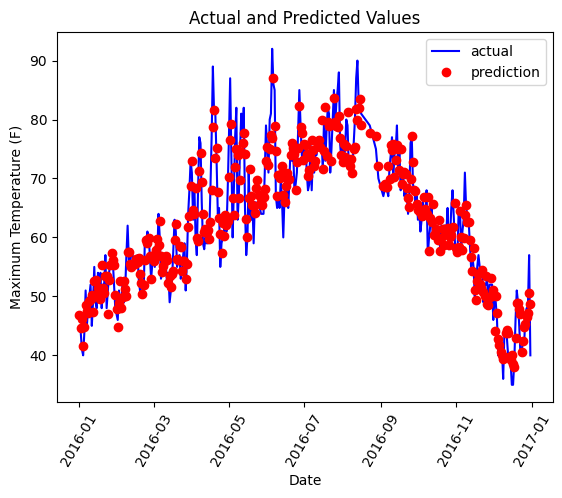

In [38]:
# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})
predictions_data = pd.DataFrame(data={'date': dates, 'prediction': predict.reshape(-1)})

# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label='prediction')
plt.xticks(rotation='60')
plt.legend()

# 图名
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')
plt.show()